In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_PostMeanScore_3DLorenz_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
num_paths = 10952

In [13]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, bws

In [14]:
config = get_config()
global_files, true_files, local_files, bws = get_drift_files(config=config)
local_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_000012626472909607102bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_000015942781813704202bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_000020130110267451267bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f3DLnz_DriftTrack_00002541722919593772bw_10952NPaths_00t0_3906e-03dT_27e+00Beta_28e+00Rho_10e+00Sigma_l

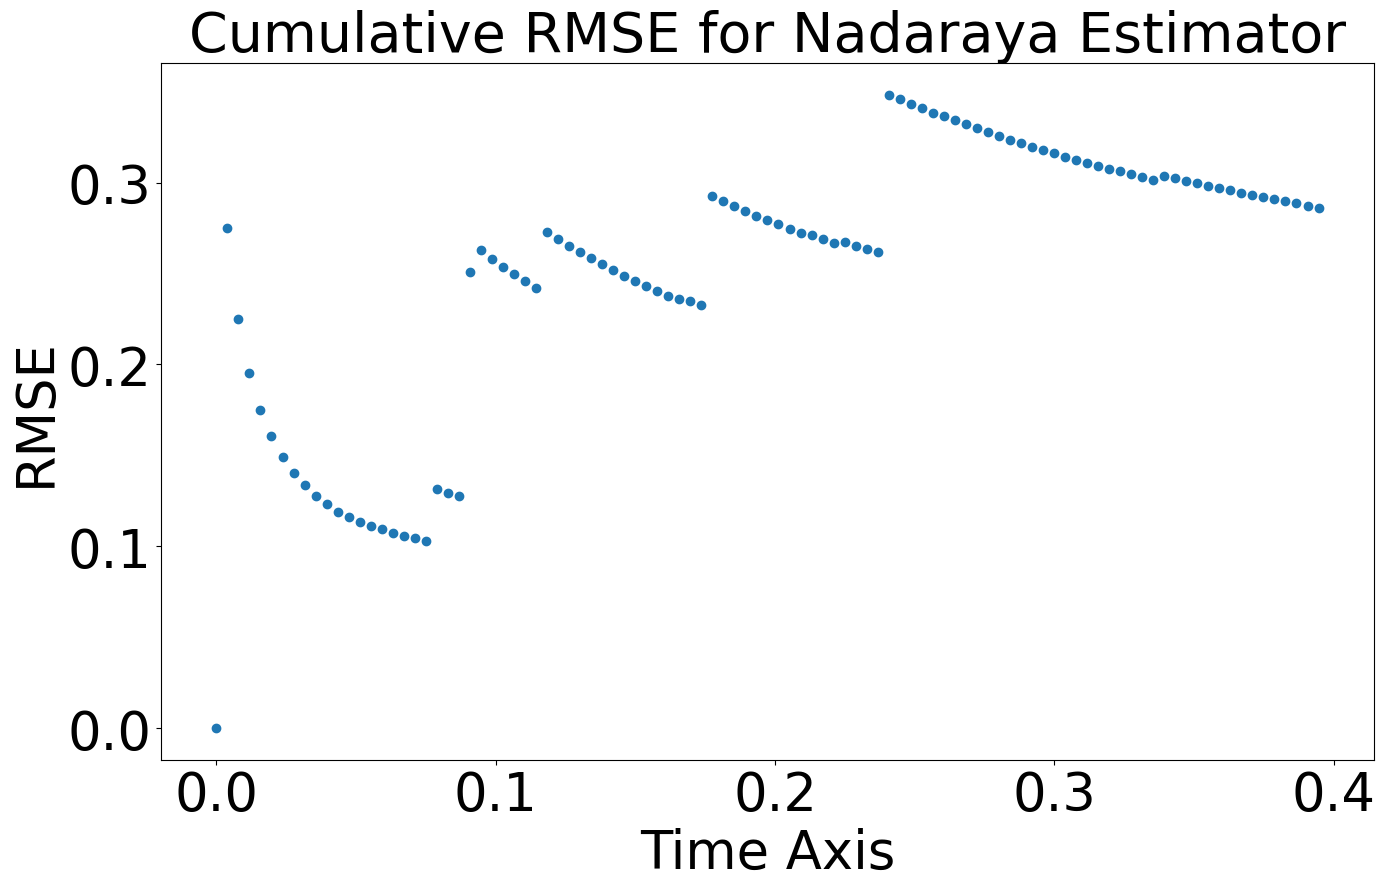

Final time cumulative RMSE local-time error 0.2861671185052602 at bw 1e-05



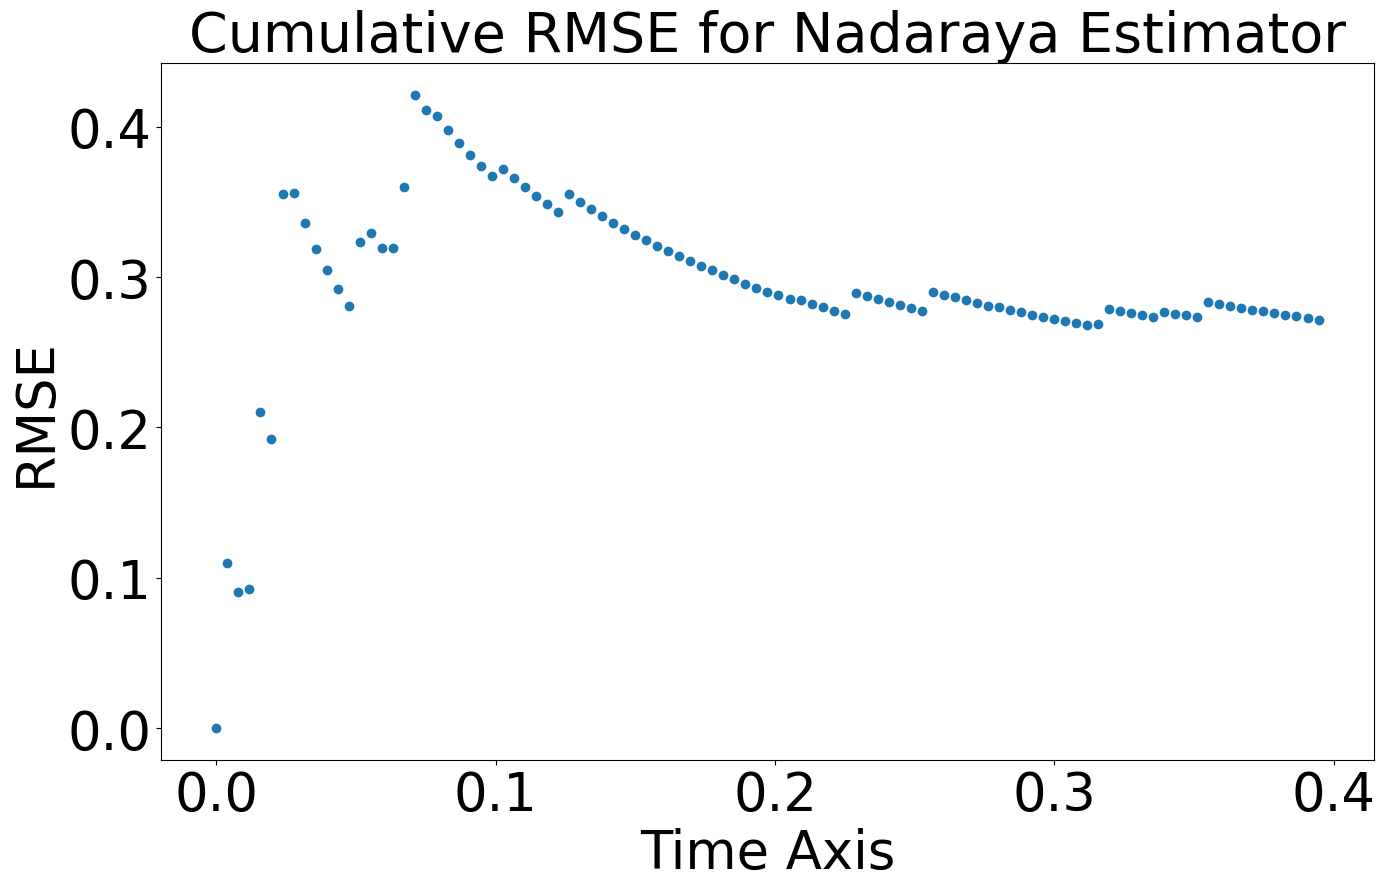

Final time cumulative RMSE local-time error 0.27162283631038137 at bw 2.0130110267451266e-05



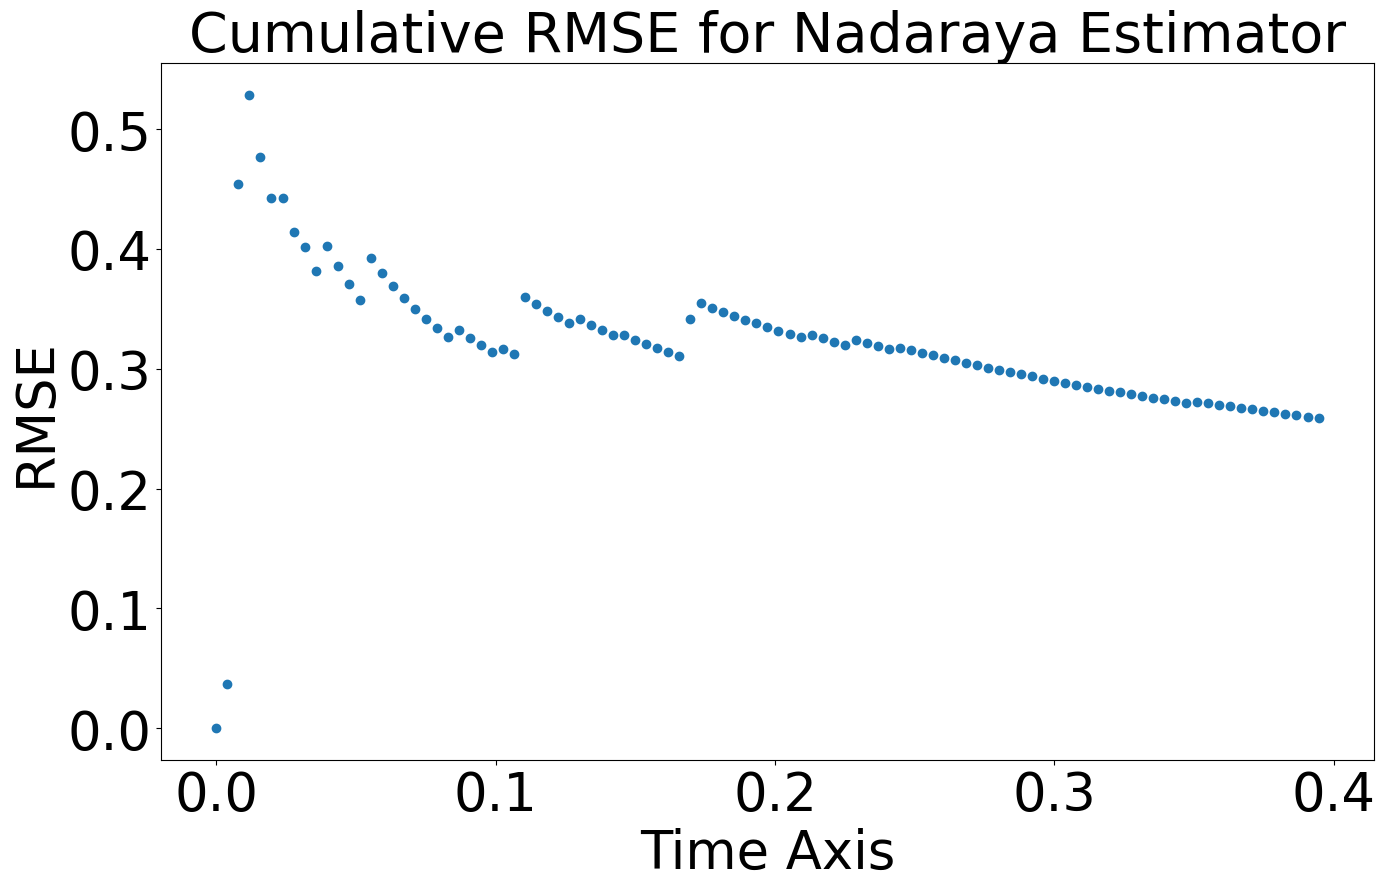

Final time cumulative RMSE local-time error 0.25893175641988736 at bw 3.2092995587978226e-05



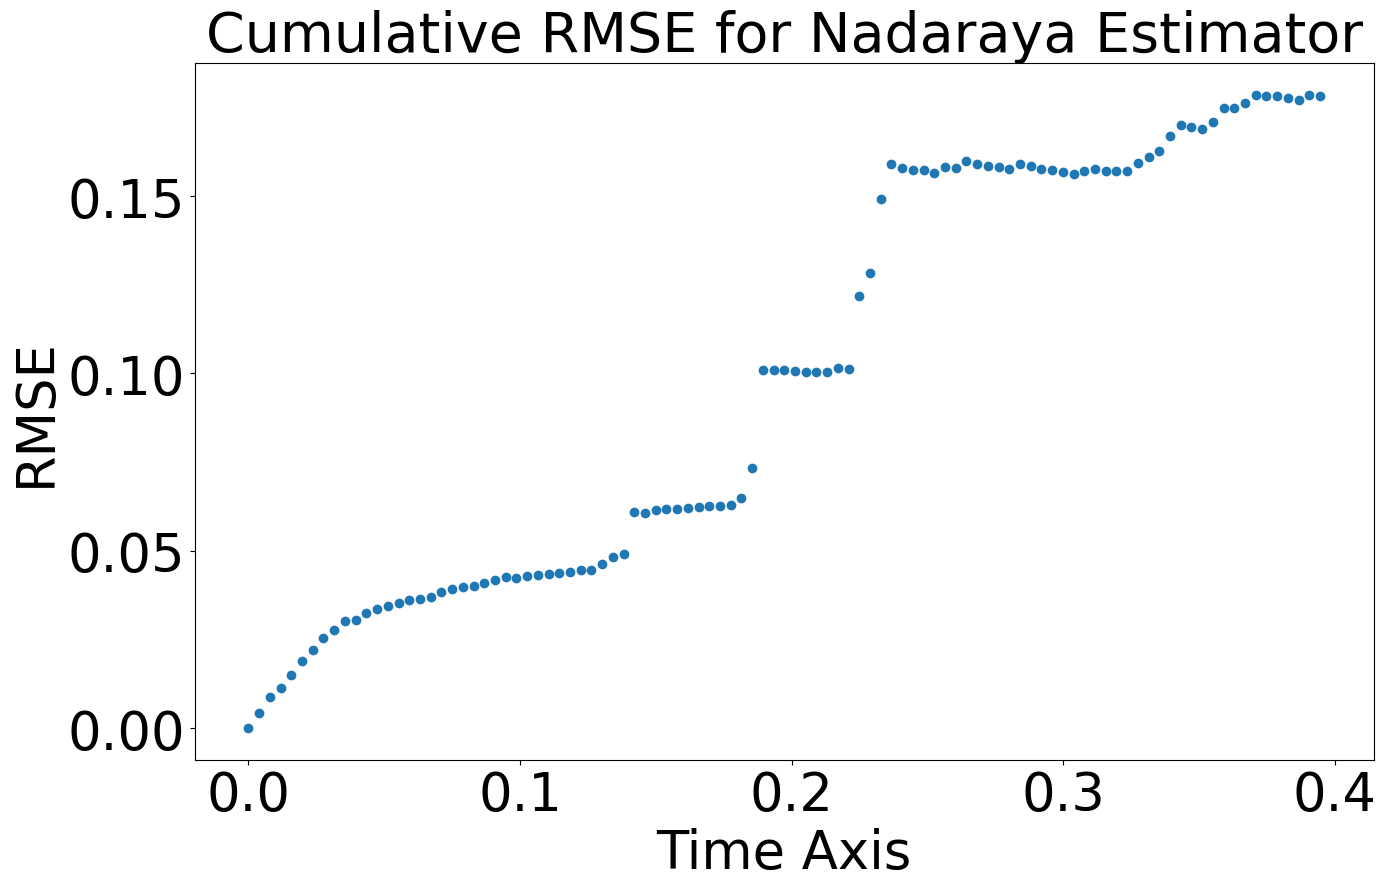

Final time cumulative RMSE local-time error 0.17825997759061787 at bw 0.003404483879113663



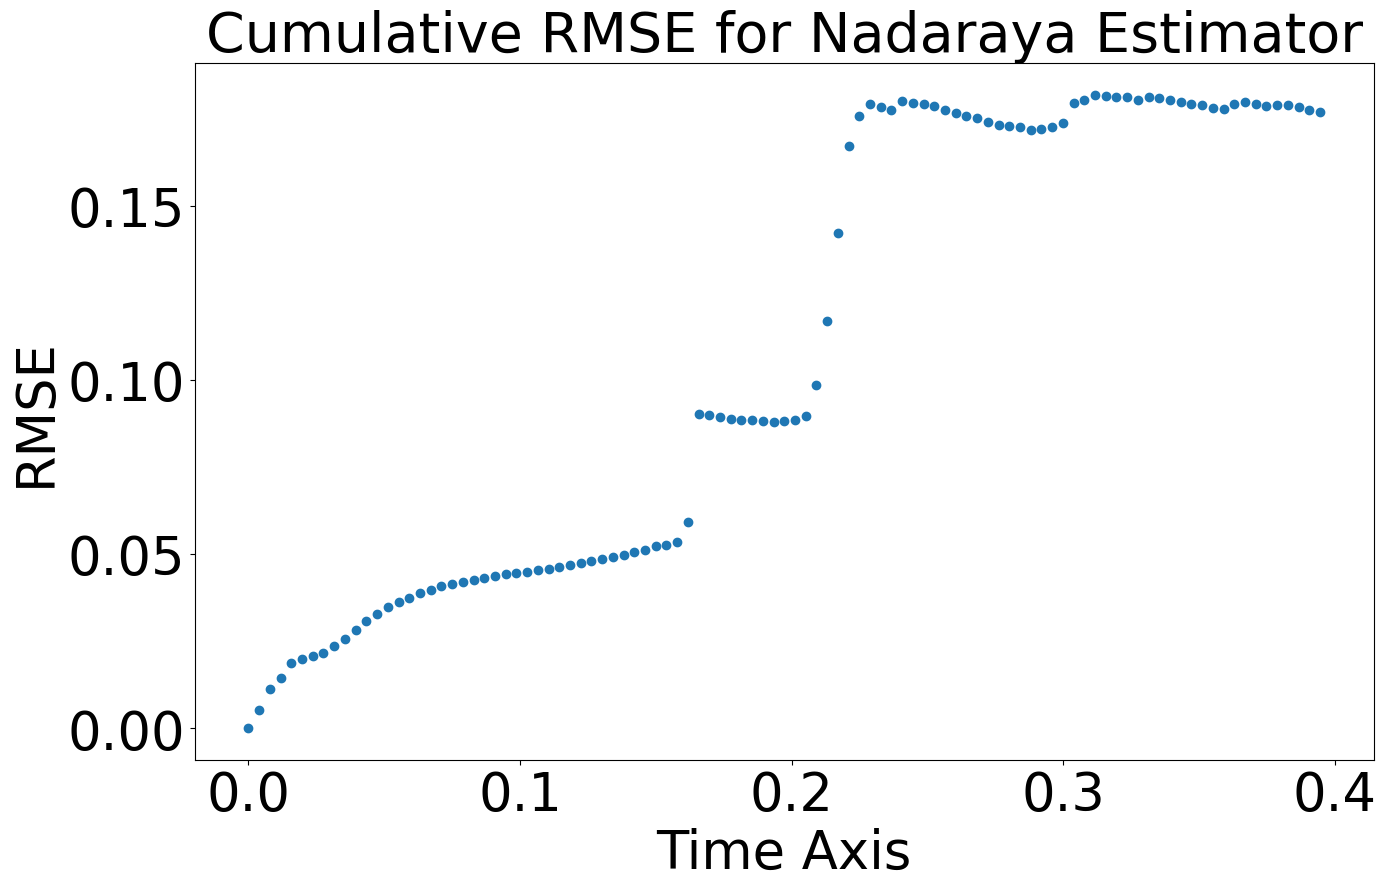

Final time cumulative RMSE local-time error 0.17696005967152503 at bw 0.004298662347082276



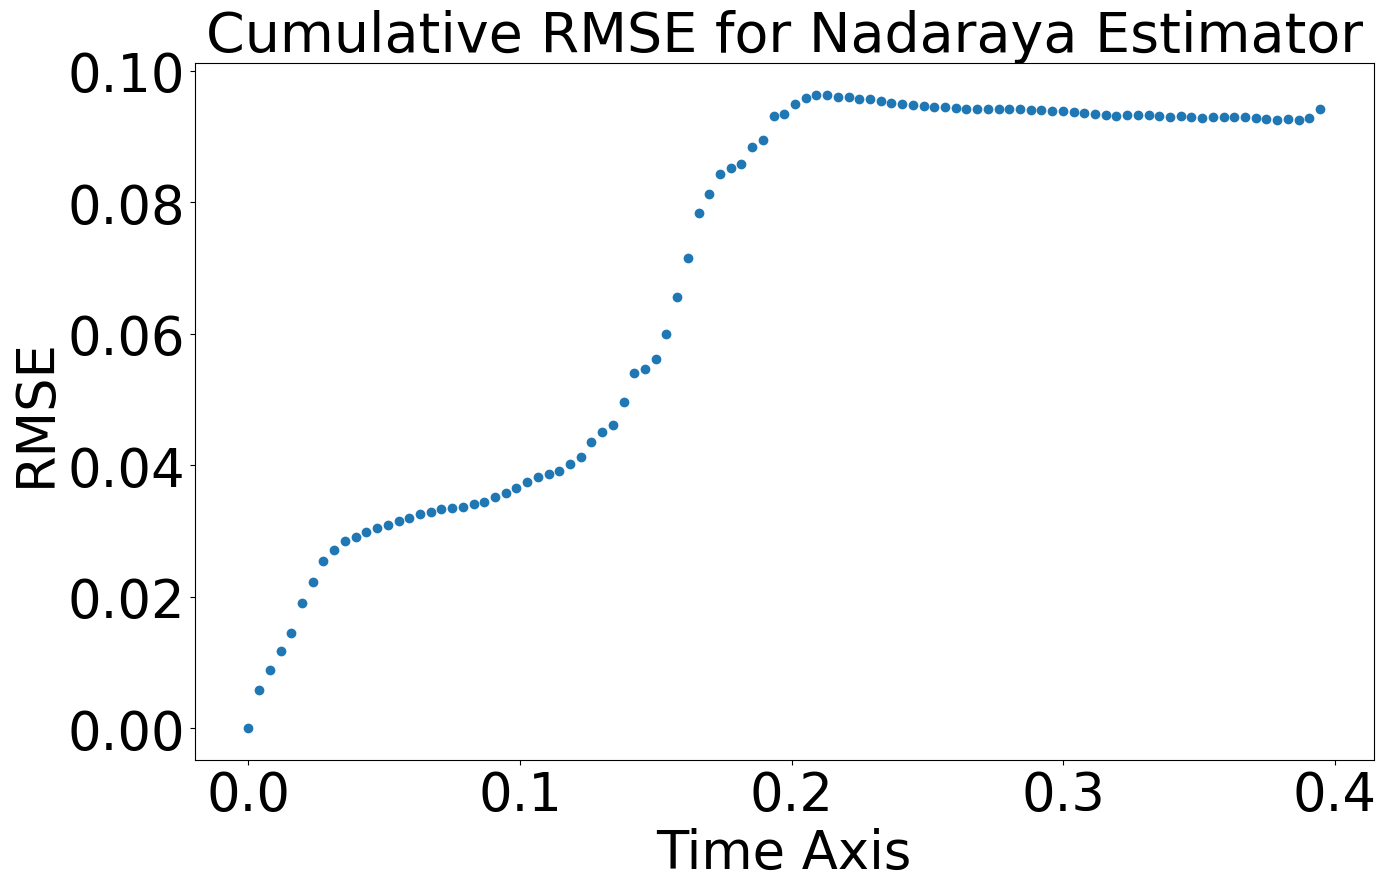

Final time cumulative RMSE local-time error 0.09421398072173147 at bw 0.005427694367298244



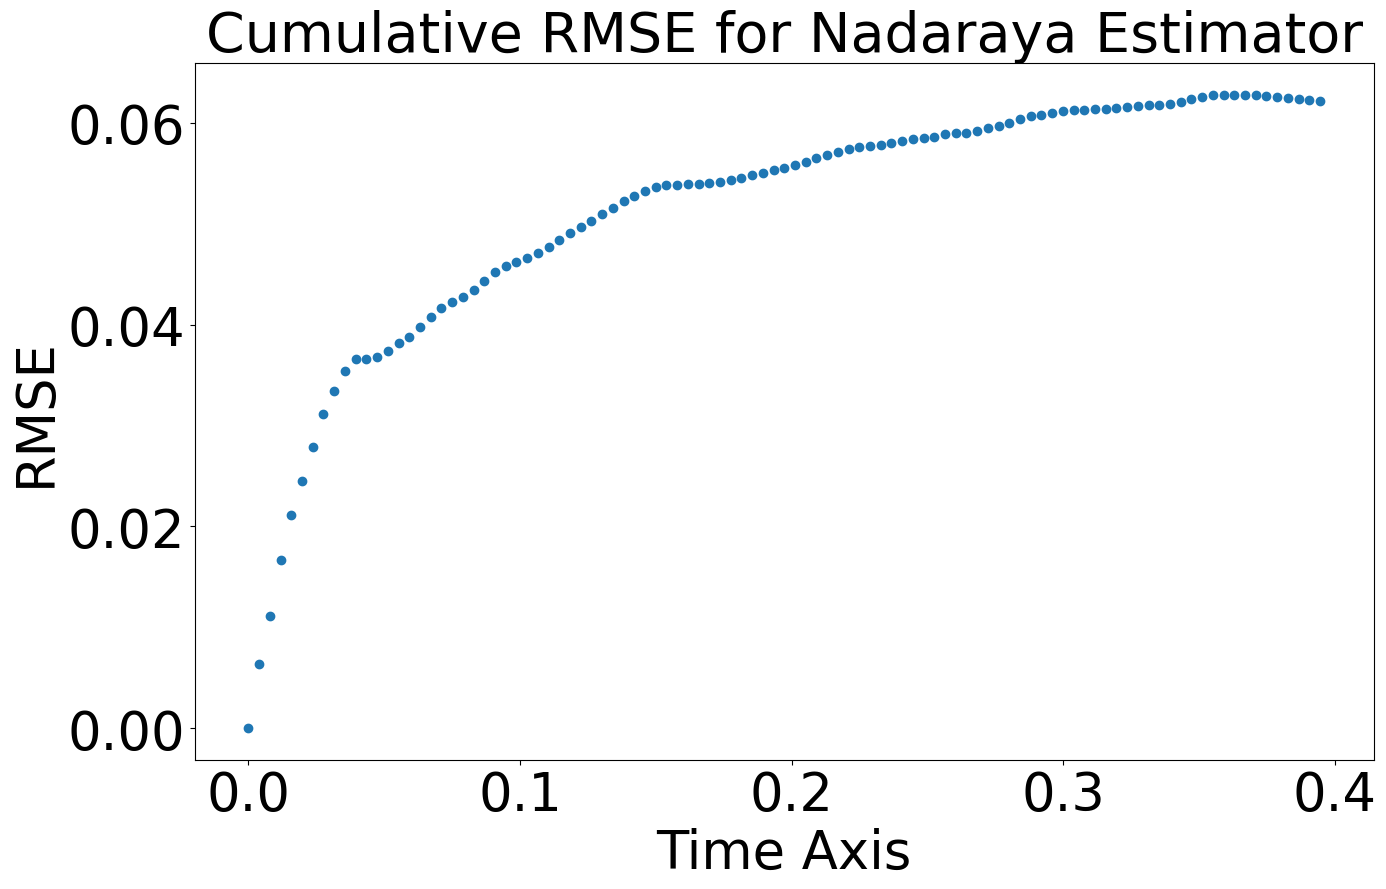

Final time cumulative RMSE local-time error 0.06217464495184168 at bw 0.006853263589031834



In [15]:
curr_rmse = np.inf
toSave = True
for file in zip(*[true_files, global_files, local_files, bws]):
    bw = file[-1]
    true_states = np.load(file[0])/np.sqrt(config.deltaT)
    local_states = np.load(file[2])/np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    if total_local_errors[-1] < curr_rmse:
        curr_rmse = total_local_errors[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
        ax.set_title(f"Cumulative RMSE for Nadaraya Estimator",fontsize=40)
        ax.set_ylabel("RMSE", fontsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        plt.tight_layout()
        if toSave:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/3DLnz_{round(bw, 4)}bw_IIDNadaraya").replace(".", "")+".png")
        plt.show()
        plt.close()
        print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at bw {bw}\n")